In [1]:
import pandas as pd 
import numpy as np
import os
os.chdir('/home/spankaew/Git/astrologics')
import astrologics as le
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
from tqdm import tqdm
from tslearn.metrics import dtw

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [25]:
model_path = "/home/spankaew/Git/astrologics/models/dev/BN_TUTO_Fx/"
model_1 = le.LogicEnsemble(model_path, project_name = 'BN_TUTO_Fx')
model_1.create_simulation()
model_1.create_attractor()
model_1.attractor.get_attractors()

Simulation object created
Attractor object created


100%|██████████| 2240/2240 [00:29<00:00, 76.59it/s]


Concatenate results into matrix


100%|██████████| 2240/2240 [00:03<00:00, 659.41it/s]


Attractors calculation completed


/home/spankaew/Git/astrologics/astrologics/model_attractors.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.attractors_df = model_logic.fillna(0)


In [79]:
model_path = "/home/spankaew/Git/astrologics/models/dev/BN_TUTO_init+Fx+Zero/"
model_2 = le.LogicEnsemble(model_path, project_name = 'BN_TUTO_init+Fx+Zero')
model_2.create_simulation()
model_2.create_attractor()
model_2.attractor.get_attractors()

Simulation object created
Attractor object created


100%|██████████| 1120/1120 [00:15<00:00, 73.84it/s]


Concatenate results into matrix


100%|██████████| 1120/1120 [00:01<00:00, 990.07it/s]

Attractors calculation completed



/home/spankaew/Git/astrologics/astrologics/model_attractors.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.attractors_df = model_logic.fillna(0)


In [ ]:
model_path = "/home/spankaew/Git/astrologics/models/dev/BN_TUTO_init+t+Fx+Zero+UnivConstraints/"
model_3 = le.LogicEnsemble(model_path, project_name = 'BN_TUTO_init+t+Fx+Zero+UnivConstraints')
model_3.create_simulation()
model_3.create_attractor()
model_3.attractor.get_attractors()

Simulation object created
Attractor object created


100%|██████████| 88/88 [00:02<00:00, 37.04it/s]


Concatenate results into matrix


100%|██████████| 88/88 [00:00<00:00, 1486.67it/s]

Attractors calculation completed



/home/spankaew/Git/astrologics/astrologics/model_attractors.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.attractors_df = model_logic.fillna(0)


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


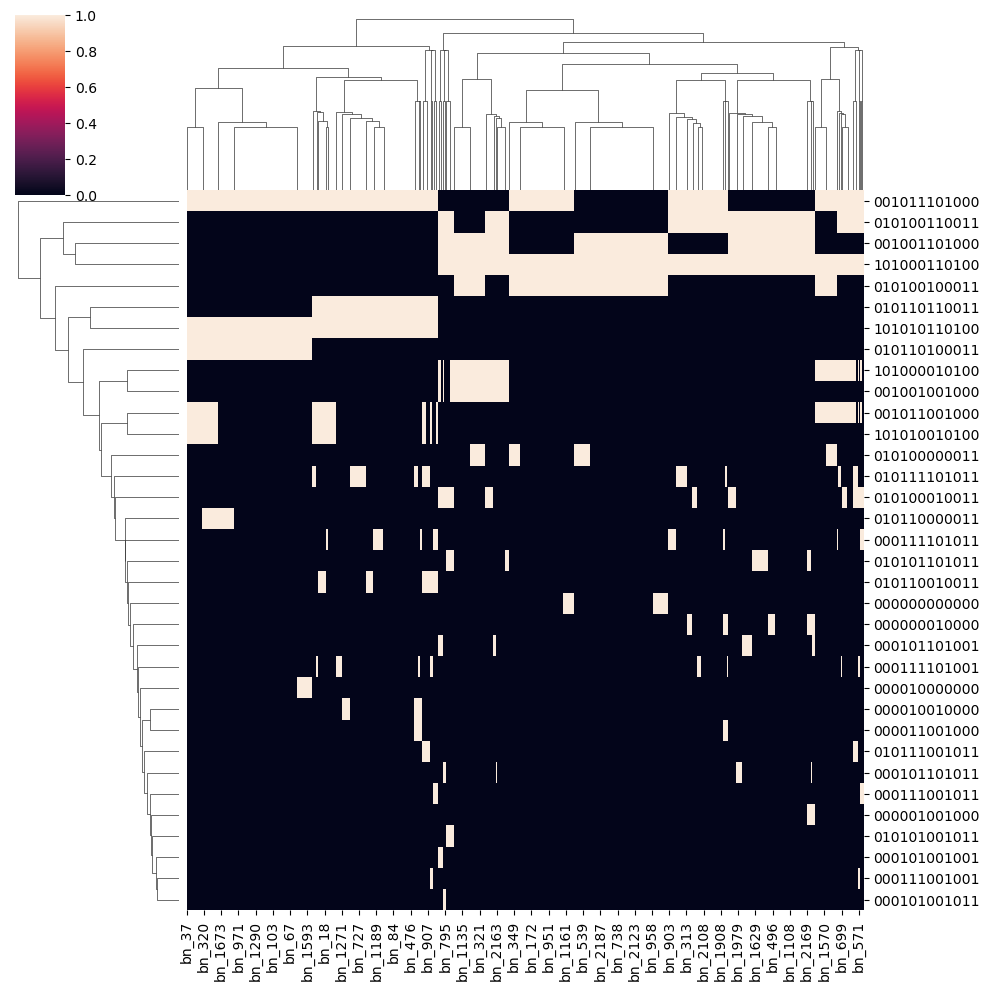

In [11]:
sns.clustermap(model_1.attractor.attractors_df)

In [19]:
concatenated_columns = model_1.attractor.attractors_df.apply(lambda col: ''.join(col.astype(str)), axis=0)
concatenated_columns.nunique()

75

In [20]:
concatenated_columns = model_2.attractor.attractors_df.apply(lambda col: ''.join(col.astype(str)), axis=0)
concatenated_columns.nunique()

60

In [21]:
concatenated_columns = model_3.attractor.attractors_df.apply(lambda col: ''.join(col.astype(str)), axis=0)
concatenated_columns.nunique()

2

In [26]:
model_path = "/home/spankaew/Git/astrologics/models/dev/BN_TUTO_Fx/"
test = pd.read_csv(model_path + 'bn_0.bnet', sep = ',', header = None)
test[1] = 0.5
test_dict = dict(zip(test[0], test[1]))

model_1.create_simulation()
# setup initial state for the simulation
model_1.simulation.update_parameters(max_time = 20)
model_1.simulation.run_simulation(initial_state = test_dict)

Simulation object created
Start simulation


100%|██████████| 2240/2240 [04:42<00:00,  7.94it/s]


Simulation completed


In [ ]:
save_path = "/home/spankaew/Git/astrologics/tmp/"
model_1.simulation.simulation_df.to_csv(save_path + 'BN_TUTO_Fx_simulation.csv', index = False)

In [28]:
def calculate_endtimepoint_distancematrix(simulation_df):
    end_timepoint = simulation_df.timepoint.unique().max()
    simulation_df = simulation_df[simulation_df.timepoint == end_timepoint]

    # Make the model_id the index
    simulation_df = simulation_df.set_index('model_id')
    model_name = simulation_df.index
    simulation_df = simulation_df.drop(columns=['timepoint'])

    # Convert simulation_df to numpy.array
    simulation_array = simulation_df.to_numpy()

    # Create the distance matrix from the simulation
    distance_matrix = squareform(pdist(simulation_array, metric='euclidean'))
    distance_matrix = pd.DataFrame(distance_matrix, columns=model_name, index=model_name)

    return(distance_matrix)

def calculate_total_distancematrix(simulation_df):
    # Make the model_id the index
    simulation_df.model_id = simulation_df.model_id.astype('category')
    node_list = simulation_df.columns.drop(['timepoint','model_id'])
    model_name = simulation_df.model_id.unique()
    
    # Convert simulation_df to numpy.array
    model_original_all = {}
    for i in model_name:
        model_original = simulation_df.loc[simulation_df.model_id == i,node_list].values
        model_original_all[i] = np.array(model_original)
    pca_all_trajectory = np.array(list(model_original_all.values()))

    # Initialize an empty distance matrix
    num_trajectories = len(pca_all_trajectory)
    distance_matrix = np.zeros((num_trajectories, num_trajectories))

    # Calculate DTW distance for each pair of trajectories
    for i in tqdm(range(num_trajectories)):
        for j in range(num_trajectories):
            distance_matrix[i, j] = dtw(pca_all_trajectory[i], pca_all_trajectory[j])

    # Display the distance matrix
    distance_matrix = pd.DataFrame(distance_matrix, index=model_name, columns=model_name)

    return(distance_matrix)

def plot_distance_matrix(distance_matrix):
    # Visualize clusters with MDS
    #distance_matrix = model.succession_diagram.distance_matrix
    mds = MDS(dissimilarity='precomputed', random_state=12345)
    coords = mds.fit_transform(distance_matrix)

    plt.figure(figsize=(6, 5))
    plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5, s = 100)
    plt.title('Distance matrix visualized with MDS')
    plt.show()

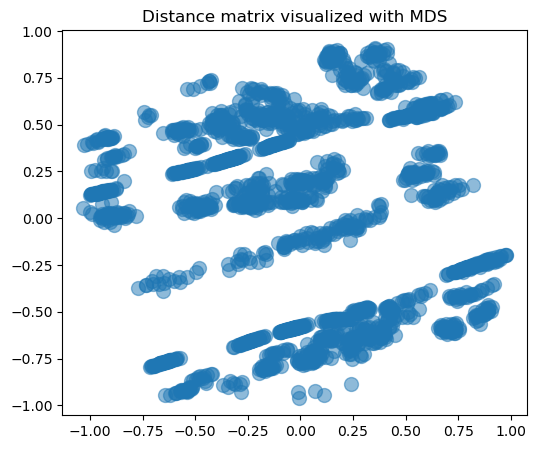

In [30]:
# Calculate the distance matrix for each simulation
all_traj_matrix = calculate_endtimepoint_distancematrix(model_1.simulation.simulation_df)
plot_distance_matrix(all_traj_matrix)

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Calculate kmeans clustering
model_1.create_trajectory()
model_1.trajectory.pca_trajectory()
model_1.trajectory.calculate_kmean_cluster(n_cluster=75, metric = 'euclidean',data = 'original')


# Get the cluster labels
concatenated_columns = model_1.attractor.attractors_df.apply(lambda col: ''.join(col.astype(str)), axis=0)
unique_labels = {label: idx + 1 for idx, label in enumerate(concatenated_columns.unique())}
concatenated_columns = concatenated_columns.map(unique_labels)

# Create a DataFrame from the cluster dictionary
cluster_df = pd.DataFrame.from_dict(model_1.trajectory.cluster_dict, orient='index', columns=['Cluster'])
cluster_df = pd.concat([cluster_df, concatenated_columns], axis=1).rename(columns={0: 'Attractor'}).rename(columns={'index': 'model_id'})

Trajectory object created
Euclidean k-means


/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.206 --> 0.122 --> 0.120 --> 0.120 --> 0.120 --> 0.120 --> 
Adjusted Rand Index: 0.6421413409145355


/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)


In [89]:
ari = adjusted_rand_score(cluster_df.Cluster, cluster_df.Attractor)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.6421413409145355


In [107]:
save_path = "/home/spankaew/Git/astrologics/tmp/"
model_2.simulation.simulation_df.to_csv(save_path + 'BN_TUTO_init+Fx+Zero_simulation.csv', index = False)

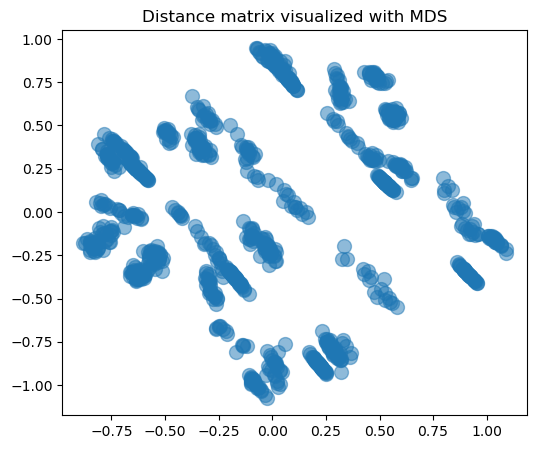

In [91]:
# Calculate the distance matrix for each simulation
all_traj_matrix_2 = calculate_endtimepoint_distancematrix(model_2.simulation.simulation_df)
plot_distance_matrix(all_traj_matrix_2)

In [104]:
model_path = "/home/spankaew/Git/astrologics/models/dev/BN_TUTO_Fx/"
test = pd.read_csv(model_path + 'bn_0.bnet', sep = ',', header = None)
test[1] = 0.5
test_dict = dict(zip(test[0], test[1]))

model_2.create_simulation()
# setup initial state for the simulation
model_2.simulation.update_parameters(max_time = 20)
model_2.simulation.run_simulation(initial_state = test_dict)

Simulation object created
Start simulation


100%|██████████| 1120/1120 [02:17<00:00,  8.14it/s]


Simulation completed


In [105]:
from sklearn.metrics import adjusted_rand_score

# Calculate kmeans clustering
model_2.create_trajectory()
model_2.trajectory.pca_trajectory()
model_2.trajectory.calculate_kmean_cluster(n_cluster=60, metric = 'euclidean',data = 'original')


# Get the cluster labels
concatenated_columns = model_2.attractor.attractors_df.apply(lambda col: ''.join(col.astype(str)), axis=0)
unique_labels = {label: idx + 1 for idx, label in enumerate(concatenated_columns.unique())}
concatenated_columns = concatenated_columns.map(unique_labels)

# Create a DataFrame from the cluster dictionary
cluster_df = pd.DataFrame.from_dict(model_2.trajectory.cluster_dict, orient='index', columns=['Cluster'])
cluster_df = pd.concat([cluster_df, concatenated_columns], axis=1).rename(columns={0: 'Attractor'}).rename(columns={'index': 'model_id'})

Trajectory object created
Euclidean k-means
0.130 --> 

/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/spankaew/anaconda3/envs/astrologics/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0.072 --> 0.072 --> 0.071 --> 0.071 --> 0.071 --> 0.071 --> 0.071 --> 0.071 --> 0.071 --> 


/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)
/home/spankaew/Git/astrologics/astrologics/trajectory_clustering.py:222: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  pca_df['kmean_cluster'] = pca_df['kmean_cluster'].replace(cluster_dict)


In [106]:
ari = adjusted_rand_score(cluster_df.Cluster, cluster_df.Attractor)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.9162481848190397
